In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, random, joblib, statistics
import sklearn as sk
import optuna
import xgboost as xgb
import plotly
import json
import math
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm, datasets
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GroupKFold
from typing import List, Optional, Tuple
import functions
from tabulate import tabulate

random.seed(1213870)

/home/ucloud/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LOADING IN ALL DATASETS AND PREPARING THEM

In [2]:
# data for model training
data = {}

for i in range(1,6):
    path = (f'./5runs_data/Preprop_data_w_folds/Preprop_data_w_folds_{i}')

    data[f'MatchingGame_{i}'] = pd.read_csv(os.path.join(path,'MatchingGame_w_5folds.csv'), delimiter=';')
    data[f'Questions_fam_{i}'] = pd.read_csv(os.path.join(path, 'Questions_fam_w_5folds.csv'), delimiter=';')
    data[f'Questions_unfam_{i}'] = pd.read_csv(os.path.join(path, 'Questions_unfam_w_5folds.csv'), delimiter=';')



In [3]:
# data for model testing
test = {}

for i in range(1,6):
    path2 = (f'./5runs_data/test_sets/test_sets_{i}')

    test[f'MG_MG_20_{i}'] = pd.read_csv(os.path.join(path2,'MG/test_MatchingGame_20.csv'), delimiter=';')
    test[f'MG_Qfam_20_{i}'] = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_20.csv'), delimiter=';')
    test[f'MG_Qfam_80_{i}'] = pd.read_csv(os.path.join(path2,'MG/test_Questions_fam_80.csv'), delimiter=';')
    test[f'Qfam_MG_20_{i}'] = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_20.csv'), delimiter=';')
    test[f'Qfam_MG_80_{i}'] = pd.read_csv(os.path.join(path2,'Qfam/test_MatchingGame_80.csv'), delimiter=';')
    test[f'Qfam_Qfam_20_{i}'] = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_fam_20.csv'), delimiter=';')
    test[f'Qfam_Qunfam_20_{i}'] = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_20.csv'), delimiter=';')
    test[f'Qfam_Qunfam_80_{i}'] = pd.read_csv(os.path.join(path2,'Qfam/test_Questions_unfam_80.csv'), delimiter=';')
    test[f'Qunfam_Qfam_20_{i}'] = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_20.csv'), delimiter=';')
    test[f'Qunfam_Qfam_80_{i}'] = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_fam_80.csv'), delimiter=';')
    test[f'Qunfam_Qunfam_20_{i}'] = pd.read_csv(os.path.join(path2,'Qunfam/test_Questions_unfam_20.csv'), delimiter=';')


In [4]:
# loading the feature lists
features = {}

for i in range(1,6):
    path3 = (f'./5runs_data/feature_lists/feature_lists_{i}')

    features[f'MG_{i}'] = pd.read_csv(os.path.join(path3,'MatchingGame_5fold_featurelist.csv'), delimiter=';')
    features[f'Qfam_{i}'] = pd.read_csv(os.path.join(path3, 'Questions_fam_5fold_featurelist.csv'), delimiter=';')
    features[f'Qunfam_{i}'] = pd.read_csv(os.path.join(path3, 'Questions_unfam_5fold_featurelist.csv'), delimiter=';')

# XGB

### Matching Game

In [ ]:
# HYPERPARAMETERTUNING
params = {}

for i in range(1,6):
    params[f'bestparams_MG_{i}'] = functions.parametertuner(
        train = data[f'MatchingGame_{i}'], 
        feature_lists = features[f'MG_{i}'], 
        train_name = f'MatchingGame_{i}', 
        trials = 100, 
        jobs = 16)

In [6]:
# loading in best params
params = {}

for i in range(1, 6):
    params[f'bestparams_MG_{i}'] = functions.extract_bestparams(f'MatchingGame_{i}')

In [7]:
# Training:
training = {}

for i in range(1,6):
    training[f'MG_training_{i}'] = functions.modeltraining(train = data[f'MatchingGame_{i}'],
                feature_lists = features[f'MG_{i}'],
                bestparams = params[f'bestparams_MG_{i}'],
                train_name = f'MatchingGame_{i}',
                save = False)

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [8]:
# extracting feature importance

for i in range(1,6):
    functions.feature_importance(f'MatchingGame_{i}', features[f'MG_{i}'], save = True)

In [9]:
# Testing:
testing = {}

for i in range(1,6):
    testing[f'MG_MG_20_test_{i}'] = functions.modeltesting(
        feature_lists=features[f'MG_{i}'],
        test=test[f'MG_MG_20_{i}'],
        save=True,
        test_name=f"MG_MG_20_{i}",
        train_name=f'MatchingGame_{i}'
    )

    test[f'MG_Qfam_80_test_{i}'] = functions.modeltesting(
        feature_lists=features[f'MG_{i}'],
        test=test[f'MG_Qfam_80_{i}'],
        save=True,
        test_name=f"MG_Qfam_80_{i}",
        train_name=f'MatchingGame_{i}'
    )

    test[f'MG_Qfam_20_test_{i}'] = functions.modeltesting(
        feature_lists=features[f'MG_{i}'],
        test=test[f'MG_Qfam_20_{i}'],
        save=True,
        test_name=f"MG_Qfam_20_{i}",
        train_name=f'MatchingGame_{i}'
    )

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

### Convo with Caregiver

In [ ]:
# PARAMETERTUNING

for i in range(1,6):
    params[f'bestparams_Qfam_{i}'] = functions.parametertuner(
        train = data[f'Questions_fam_{i}'], 
        feature_lists = features[f'Qfam_{i}'],
        train_name = f'Qfam_{i}', 
        trials = 100, 
        jobs = 16)

In [5]:
#loading in best params
params = {}

for i in range(1, 6):
    params[f'bestparams_Qfam_{i}'] = functions.extract_bestparams(f'Qfam_{i}')

In [ ]:
# training
training = {}
for i in range(1,6):
    training[f'Qfam_training_{i}'] = functions.modeltraining(train = data[f'Questions_fam_{i}'],
                feature_lists = features[f'Qfam_{i}'],
                bestparams = params[f'bestparams_Qfam_{i}'],
                train_name =f'Qfam_{i}',
                save = True)

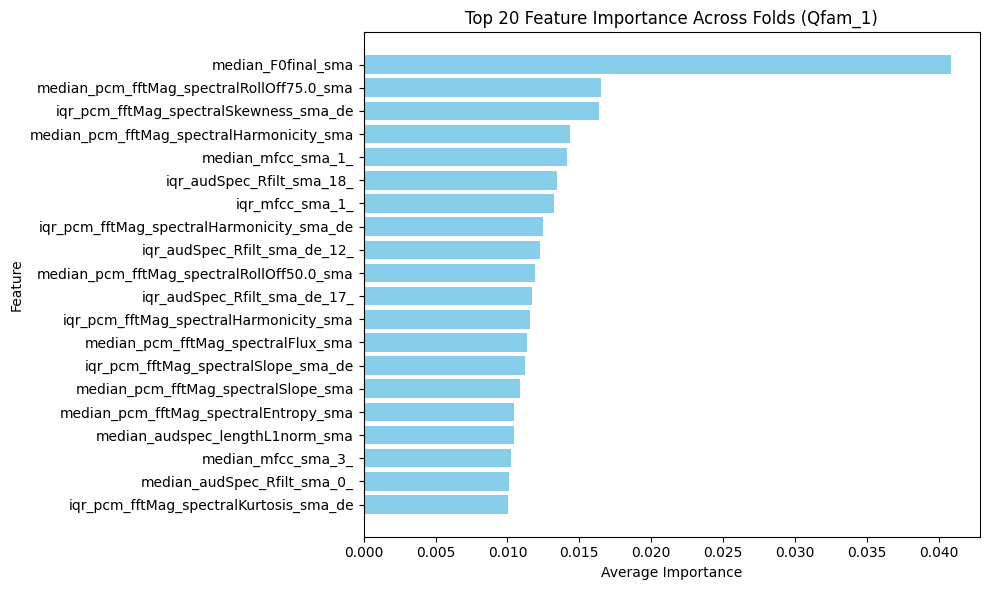

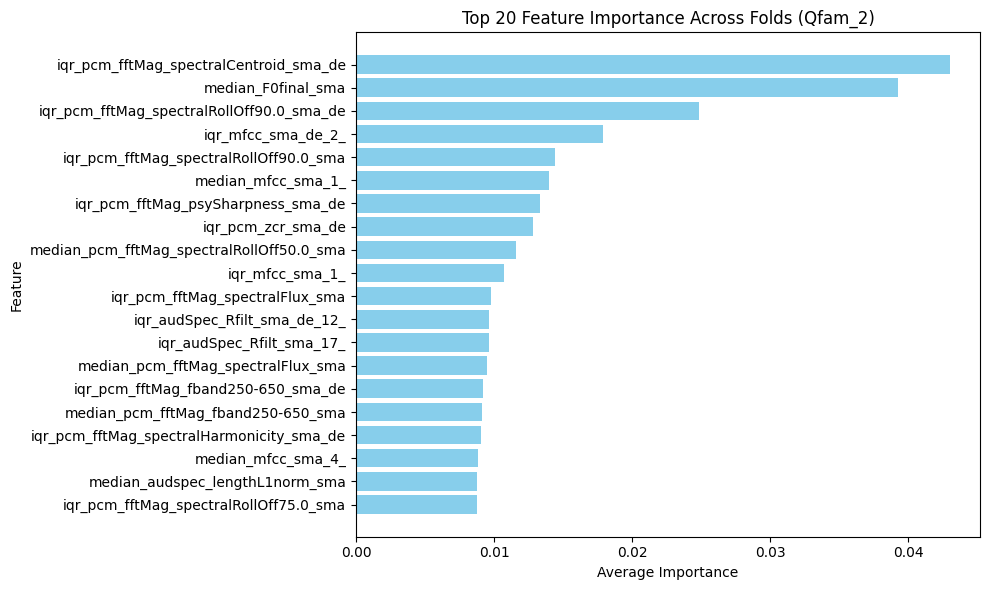

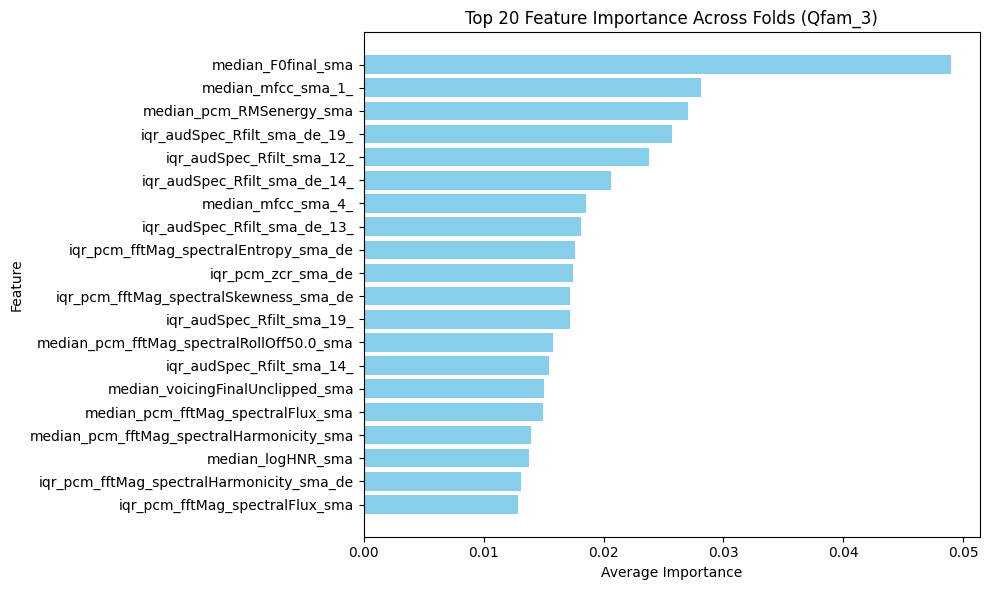

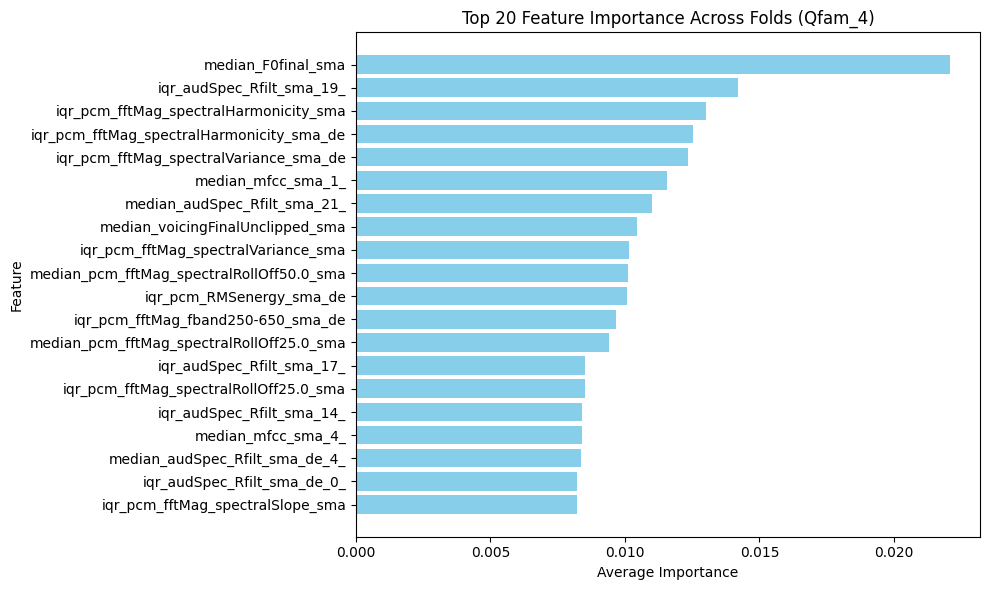

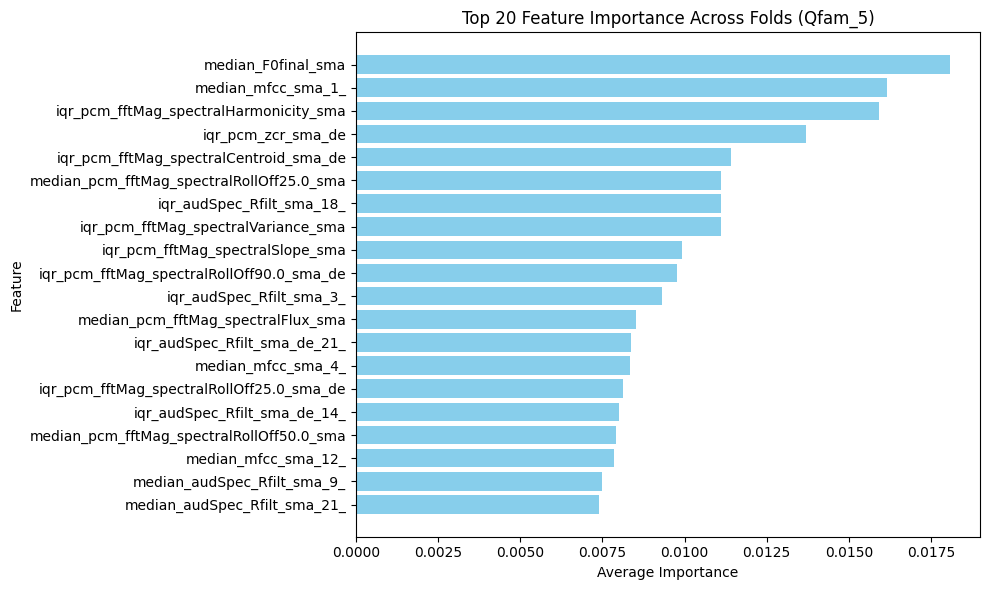

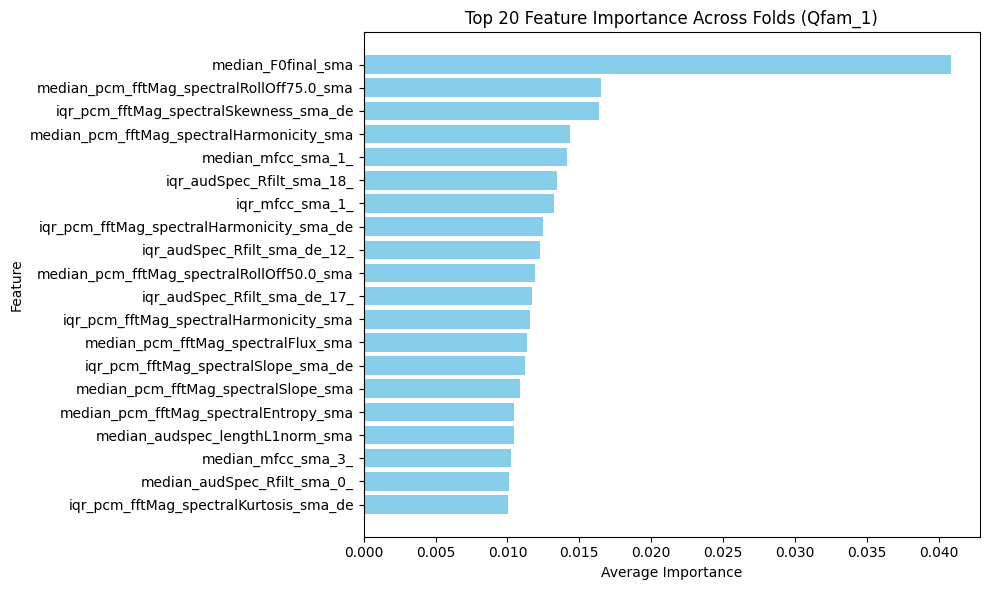

,Feature,Importance
127,median_F0final_sma,0.040829
236,median_pcm_fftMag_spectralRollOff75.0_sma,0.016492
116,iqr_pcm_fftMag_spectralSkewness_sma_de,0.016345
228,median_pcm_fftMag_spectralHarmonicity_sma,0.014343
191,median_mfcc_sma_1_,0.014136
11,iqr_audSpec_Rfilt_sma_18_,0.013441
66,iqr_mfcc_sma_1_,0.013235
104,iqr_pcm_fftMag_spectralHarmonicity_sma_de,0.012509
30,iqr_audSpec_Rfilt_sma_de_12_,0.012286
234,median_pcm_fftMag_spectralRollOff50.0_sma,0.011917


In [ ]:
# feature importance analysis

for i in range(1,6):
    functions.feature_importance(f'Qfam_{i}', features[f'Qfam_{i}'], save = True)

In [8]:
# Testing:
testing = {}
for i in range(1,6):
    testing[f'Qfam_qfam_20_test_{i}'] = functions.modeltesting(
                feature_lists = features[f'Qfam_{i}'],
                test = test[f'Qfam_Qfam_20_{i}'],
                save = True,
                test_name = f"Qfam_Qfam_20_{i}",
                train_name = f'Qfam_{i}')

    testing[f'Qfam_MG_80_test_{i}'] = functions.modeltesting(
                feature_lists = features[f'Qfam_{i}'],
                test = test[f'Qfam_MG_80_{i}'],
                save = True,
                test_name = f"Qfam_MG_80_{i}",
                train_name = f'Qfam_{i}')

    testing[f'Qfam_MG_20_test_{i}'] = functions.modeltesting(
                feature_lists = features[f'Qfam_{i}'],
                test = test[f'Qfam_MG_20_{i}'],
                save = True,
                test_name = f"Qfam_MG_20_{i}",
                train_name = f'Qfam_{i}') 

    testing[f'Qfam_Qunfam_20_test_{i}'] = functions.modeltesting(
                feature_lists = features[f'Qfam_{i}'],
                test = test[f'Qfam_Qunfam_20_{i}'],
                save = True,
                test_name = f"Qfam_Qunfam_20_{i}",
                train_name = f'Qfam_{i}')

    testing[f'Qfam_Qunfam_80_test_{i}'] = functions.modeltesting(
                feature_lists = features[f'Qfam_{i}'],
                test = test[f'Qfam_Qunfam_80_{i}'],
                save = True,
                test_name = f"Qfam_Qunfam_80_{i}",
                train_name = f'Qfam_{i}')

### Convo With Experimenter

In [ ]:
# PARAMETERTUNING

for i in range(1,6):
    params[f'bestparams_Qunfam_{i}'] = functions.parametertuner(
        train = data[f'Questions_unfam_{i}'], 
        feature_lists = features[f'Qunfam_{i}'],
        train_name = f'Qunfam_{i}', 
        trials = 100, 
        jobs = 16)

In [73]:
# loading in best params

for i in range(1,6):
    params[f'bestparams_Qunfam_{i}'] = functions.extract_bestparams(f'Q_unfam_{i}')

In [10]:
#Training
for i in range(1,6):
    training[f'Qunfam_training_{i}'] = functions.modeltraining(train = data[f'Questions_unfam_{i}'],
                feature_lists = features[f'Qunfam_{i}'],
                bestparams = params[f'bestparams_Qunfam_{i}'],
                train_name = f'Qunfam_{i}',
                save = True)

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [75]:
# feature importance analysis
for i in range(1, 6):
    functions.feature_importance(f'Qunfam_{i}', features[f'Qunfam_{i}'], save = True)

In [11]:
# Testing:
for i in range(1,6):
    testing[f'Qunfam_qunfam_20_test_{i}'] = functions.modeltesting(
                features[f'Qunfam_{i}'],
                test[f'Qunfam_Qunfam_20_{i}'],
                save = True,
                test_name = f"Qunfam_Qunfam_20_{i}",
                train_name = f'Qunfam_{i}')

    testing[f'Qunfam_Qfam_80_test_{i}'] = functions.modeltesting(
                features[f'Qunfam_{i}'],
                test[f'Qunfam_Qfam_80_{i}'],
                save = True,
                test_name = f"Qunfam_Qfam_80_{i}",
                train_name = f'Qunfam_{i}')

    testing[f'Qunfam_Q_fam_20_test_{i}'] = functions.modeltesting(
                features[f'Qunfam_{i}'],
                test[f'Qunfam_Qfam_20_{i}'],
                save = True,
                test_name = f"Qunfam_Qfam_20_{i}",
                train_name = f'Qunfam_{i}')

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ucloud/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont